# Neural machine translation with attention

In [ ]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

Data set is for spanish to english translation

In [ ]:
# Download the file
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

2646016/2638744 [==============================] - 0s 0us/step


In [ ]:
with open(path_to_file, "r") as fin:
    lines = fin.readlines()
for i in range(10):
  print(lines[i])

Go.	Ve.

Go.	Vete.

Go.	Vaya.

Go.	Váyase.

Hi.	Hola.

Run!	¡Corre!

Run.	Corred.

Who?	¿Quién?

Fire!	¡Fuego!

Fire!	¡Incendio!



Preprocessing is the first the first step for any input data. We define all the functions necessary for preprocessing.

In [ ]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
                 if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  #convert unicode to ascii
  w = unicode_to_ascii(w.lower().strip())

  #leave space between words and punctuation marks
  #  hello! ---> hello !
  w = re.sub(r"([?.!,¿])", r" \1 ", w)

  #  it's ---> it s
  w = re.sub(r'[" "]+', " ", w)

  # removing all special characters
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  #add start and end tag
  w = '<start> ' + w + ' <end>'
  return w

In [ ]:
#To test the working of preprocess function
en_sentence = u"May I borrow this book?"
print(preprocess_sentence(en_sentence))

<start> may i borrow this book ? <end>


In [ ]:
#Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in line.split('\t')]
                for line in lines[:num_examples]]

  return zip(*word_pairs)

In [ ]:
#Test the working of create data set function
en, sp = create_dataset(path_to_file, None)
print("Sample pair")
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [ ]:
def tokenize(lang):
  #create a tokenizer object to split text with '' as delimiter
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')  

  #fit the created tokenizer object to the input corpus, this will do word to index mapping
  lang_tokenizer.fit_on_texts(lang) 

  #form integer sequence for each input text based on the index mapping
  tensor = lang_tokenizer.texts_to_sequences(lang)

  #all sequences must be of same length. To achieve that, pad every sequence with zeros till
  #the sequence length matches the length of the biggest sentence in the corpus.
  #By default, pad_sequences function adds zeros till max length 
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

  return tensor, lang_tokenizer

In [ ]:
#Returns two tensors and two tokenizers, one for each corpus
def load_dataset(path, num_examples=None):
  targ_lang, inp_lang = create_dataset(path, num_examples)

  #input language and target language are two separate corpus.
  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [ ]:
# We have more than 100000 data. To complete the process fast, we pick only 30000
#more the samples for training, more will be the accuracy
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file,
                                                                num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [ ]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


In [ ]:
#display the index word mapping for the given corpus
def convert(lang, tensor):
  for t in tensor:
    if t != 0:
      print(f'{t} ----> {lang.index_word[t]}')

In [ ]:
print("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print()
print("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
4 ----> tom
8 ----> no
66 ----> puede
6464 ----> rehusarse
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
5 ----> tom
25 ----> can
12 ----> t
1097 ----> refuse
3 ----> .
2 ----> <end>


Now that all the preprocessing is done, data is ready for training, we can build the encoder decoder model. We initialize all the necessary parameters. The sequence is in the form of an array. We need to store it efficiently in the memory. For that, we use **tf.data.Dataset.from_tensor_slices**. This slices the array and stores it as an object.
We group the data into batches with 64 in each batch using **dataset.batch** function. drop_remainder is set to true. if there is any remaining data after grouping into batches, we are going to drop them.

In [ ]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
#we check the dimension of the data
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

**Designing the encoder.**

Encoder decoder architecture generally uses LSTM or GRU. Here we go for GRU. In normal seq2seq model, output from the final encoder unit is alone enough. but in case of model with attention, we need output of each and every unit of the encoder along with the summary obtained from the final unit. **return_sequences** is set to true. This returns output from every encoder unit. **return_state** is set to true so that, the final summary(internal state of GRU) is obtained.

**Workflow of Encoder**

The sequence of integers is given as the input. This input is passed through the embedding layer. The role of the embedding layer is to convert the input into a fixed size dense vector. Initially, the hidden layer is arbitrary ( here we initialize it as zeros ). we pass the output of the embedding layer and hidden layer values to GRU. As discussed above, GRU returns the output sequence and the summary.

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state=hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

Let's check the working of the Encoder model defined aboveand analyze the dimensions.

output dimension is 64 x 16 x 1024. 64 is the batch size, 16 is the length of the sequence and 1024 is the number of units.

dimension of summary is obviously 64 x 1024

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print('Encoder output shape: (batch size, sequence length, units)', sample_output.shape)
print('Encoder Hidden state shape: (batch size, units)', sample_hidden.shape)

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


Next we need to design Attention layer. Here we use Bahdanau Attention mechanism. This layer just follows the algorithm of Bahdanau. We use the formula to calculate score, attention weights and context vector.

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units)", attention_result.shape)
print("Attention weights shape: (batch_size, sequence_length, 1)", attention_weights.shape)

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


We now design the decoder. Decoder is similar to encoder. In addition to that, we do predictions. The input for a decoder unit will be output of the previous unit (for the first unit <start> tag acts as input), hidden layer values of previous unit (for the first unit, it will be the summary of the encoder) and the context vector. This method in which we feed the output of the decoder unit to the next unit is called Teacher forcing.

In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print('Decoder output shape: (batch_size, vocab size)', sample_decoder_output.shape)

Decoder output shape: (batch_size, vocab size) (64, 4935)


We use **Adam oprtimizer**. Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments. We use SparseCategoricalCrossentropy as the loss function. **SparseCategoricalCrossentropy** computes the crossentropy loss between the labels and predictions. Use this crossentropy loss function when there are two or more label classes. We expect labels to be provided as integers. If you want to provide labels using one-hot representation, please use CategoricalCrossentropy loss. There should be # classes floating point values per feature for y_pred and a single floating point value per feature for y_true.

loss_function:

we have sequences with padding. when calculating loss, padding is not considered. Because of this, loss calculation will go wrong. To avoid this, while calculating loss, we need to consider only non-zero values. While updating loss, we are going to hide zeros. mask will store boolean value. True for non zero values. then, it is multiplied with the loss. In the places where mask is false, loss won't be updated.

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

We use check point to save the variables then and there. A function must have **@tf.function** decorator for using checkpoint. So, train_step function is given that decorator.

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy():.4f}')
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix=checkpoint_prefix)

  print(f'Epoch {epoch+1} Loss {total_loss/steps_per_epoch:.4f}')
  print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 4.5058
Epoch 1 Batch 100 Loss 2.2514
Epoch 1 Batch 200 Loss 1.8439
Epoch 1 Batch 300 Loss 1.7653
Epoch 1 Loss 2.0397
Time taken for 1 epoch 45.10 sec

Epoch 2 Batch 0 Loss 1.5606
Epoch 2 Batch 100 Loss 1.5066
Epoch 2 Batch 200 Loss 1.3426
Epoch 2 Batch 300 Loss 1.2542
Epoch 2 Loss 1.3834
Time taken for 1 epoch 33.60 sec

Epoch 3 Batch 0 Loss 1.0938
Epoch 3 Batch 100 Loss 0.9463
Epoch 3 Batch 200 Loss 0.9644
Epoch 3 Batch 300 Loss 0.8526
Epoch 3 Loss 0.9508
Time taken for 1 epoch 32.98 sec

Epoch 4 Batch 0 Loss 0.7004
Epoch 4 Batch 100 Loss 0.6239
Epoch 4 Batch 200 Loss 0.5862
Epoch 4 Batch 300 Loss 0.6187
Epoch 4 Loss 0.6400
Time taken for 1 epoch 33.39 sec

Epoch 5 Batch 0 Loss 0.4587
Epoch 5 Batch 100 Loss 0.3707
Epoch 5 Batch 200 Loss 0.4467
Epoch 5 Batch 300 Loss 0.4376
Epoch 5 Loss 0.4326
Time taken for 1 epoch 32.81 sec

Epoch 6 Batch 0 Loss 0.2421
Epoch 6 Batch 100 Loss 0.3252
Epoch 6 Batch 200 Loss 0.2907
Epoch 6 Batch 300 Loss 0.3061
Epoch 6 Loss 0.2982
Ti

In [ ]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [ ]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input:', sentence)
  print('Predicted translation:', result)

  attention_plot = attention_plot[:len(result.split(' ')),
                                  :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s very cold here . <end> 


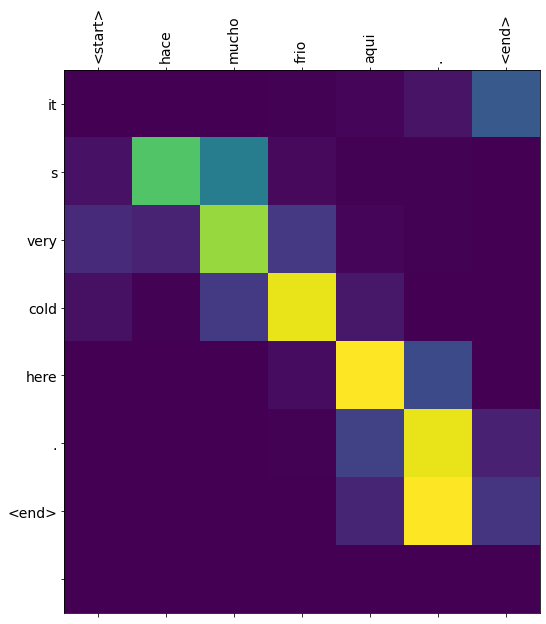

In [ ]:
translate(u'hace mucho frio aqui.')

Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


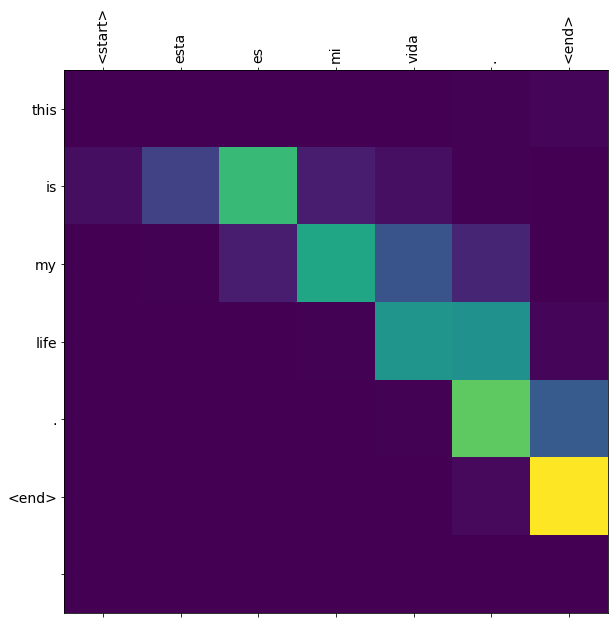

In [ ]:
translate(u'esta es mi vida.')

Input: <start> ¿ todavia estan en casa ? <end>
Predicted translation: are you still at home ? <end> 


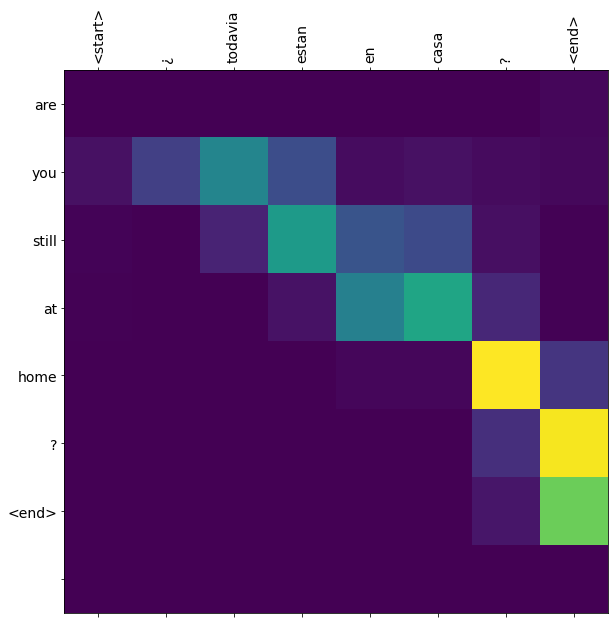

In [ ]:
translate(u'¿todavia estan en casa?')

Input: <start> ¿ puedo tomar prestado este libro ? <end>
Predicted translation: may i borrow this book ? <end> 


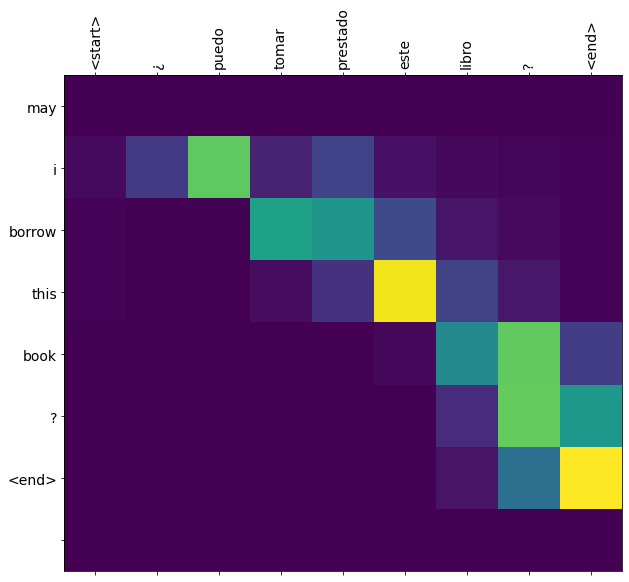

In [ ]:
translate(u'¿puedo tomar prestado este libro?')